资料:  
[XGBoost原始论文](https://arxiv.org/pdf/1603.02754v1.pdf)  
[Xgboost Slides ](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)  
(推荐)[XGBoost 与 Boosted Tree](http://www.52cs.org/?p=429)  
(推荐)[xgboost入门与实战（原理篇）](http://blog.csdn.net/sb19931201/article/details/52557382)  
[XGBoost浅入浅出](http://wepon.me/2016/05/07/XGBoost%E6%B5%85%E5%85%A5%E6%B5%85%E5%87%BA/)  
[xgboost调参演示](https://github.com/lytforgood/MachineLearningTrick/blob/master/xgboost%E8%B0%83%E5%8F%82%E6%BC%94%E7%A4%BA.md)  
[xgboost官网](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)  
[xgboost算法原理与实战](https://blog.csdn.net/jasonzhangoo/article/details/73061060)    
[利用GBDT模型构造新特征](https://breezedeus.github.io/2014/11/19/breezedeus-feature-mining-gbdt.html#fn:fbgbdt)  
[XGBoost Plotting API以及GBDT组合特征实践](https://blog.csdn.net/sb19931201/article/details/65445514)

## XGBoost

XGBoost(eXtreme Gradient Boosting)是GBDT是的一种实现,正如其名,它在原有GBDT的基础做了很多改进,在训练速度和精度上面都特别优秀.也是目前数据比赛中特别常用的算法.xgboost算法比较复杂，针对传统GBDT算法做了很多细节改进，包括损失函数、正则化、切分点查找算法优化、稀疏感知算法、并行化算法设计等等。本文主要介绍xgboost基本原理以及与传统gbdt算法对比总结，后续会基于python版本做了一些实战调参试验。想详细学习xgboost算法原理建议通读作者原始论文与slide讲解。 相关笔记 [Adaboost](https://github.com/linzhenpeng/machinelearning/blob/master/Adaboost/Adaboost.ipynb),[GBDT ](https://github.com/linzhenpeng/machinelearning/blob/master/GBDT/GBDT.ipynb) ,[决策树 ](https://github.com/linzhenpeng/machinelearning/blob/master/decisionTree/decisionTree.ipynb)  


### xgboost特点（与gbdt对比）来自[xgboost入门与实战（原理篇）](https://blog.csdn.net/sb19931201/article/details/52557382)

1. 传统GBDT以CART作为基分类器，xgboost还支持线性分类器，这个时候xgboost相当于带L1和L2正则化项的逻辑斯蒂回归（分类问题）或者线性回归（回归问题）。 —**可以通过booster [default=gbtree]设置参数:gbtree: tree-based models/gblinear: linear models**    
2. 传统GBDT在优化时只用到一阶导数信息，xgboost则对代价函数进行了二阶泰勒展开，同时用到了一阶和二阶导数。顺便提一下，xgboost工具支持自定义代价函数，只要函数可一阶和二阶求导。     
3. xgboost在代价函数里加入了正则项，用于控制模型的复杂度。正则项里包含了树的叶子节点个数、每个叶子节点上输出的score的L2模的平方和。从Bias-variance tradeoff角度来讲，正则项降低了模型variance，使学习出来的模型更加简单，防止过拟合，这也是xgboost优于传统GBDT的一个特性  **—正则化包括了两个部分，都是为了防止过拟合，剪枝是都有的，叶子结点输出L2平滑是新增的。**    
4. shrinkage and column subsampling —还是为了防止过拟合，论文2.3节有介绍，这里答主已概括的非常到位      
    （1）shrinkage缩减类似于学习速率，在每一步tree boosting之后增加了一个参数n（权重），通过这种方式来减小每棵树的影响力，给后面的树提供空间去优化模型。   
    （2）column subsampling列(特征)抽样，说是从随机森林那边学习来的，防止过拟合的效果比传统的行抽样还好（行抽样功能也有），并且有利于后面提到的并行化处理算法。    
    
5. split finding algorithms(划分点查找算法)：   
    （1）exact greedy algorithm—贪心算法获取最优切分点   
    （2）approximate algorithm— 近似算法，提出了候选分割点概念，先通过直方图算法获得候选分割点的分布情况，然后根据候选分割点将连续的特征信息映射到不同的buckets中，并统计汇总信息。详细见论文3.3节   
    (3）Weighted Quantile Sketch—分布式加权直方图算法，论文3.4节   
    这里的算法（2）、（3）是为了解决数据无法一次载入内存或者在分布式情况下算法（1）效率低的问题，以下引用的还是wepon大神的总结：  
    可并行的近似直方图算法。树节点在进行分裂时，我们需要计算每个特征的每个分割点对应的增益，即用贪心法枚举所有可能的分割点。当数据无法一次载入内存或者在分布式情况下，贪心算法效率就会变得很低，所以xgboost还提出了一种可并行的近似直方图算法，用于高效地生成候选的分割点。**xgboost里面分割特征使用的不是 gini系数也不是信息增益**  
6. 对缺失值的处理。  
    对于特征的值有缺失的样本，xgboost可以自动学习出它的分裂方向。 —稀疏感知算法，论文3.4节，Algorithm 3: Sparsity-aware Split Finding  
7. Built-in Cross-Validation（内置交叉验证)

    XGBoost允许在每一轮boosting迭代中使用交叉验证。因此，可以方便地获得最优boosting迭代次数。 
     而GBM使用网格搜索，只能检测有限个值。

8.  continue on Existing Model（接着已有模型学习）

    XGBoost可以在上一轮的结果上继续训练。 
    sklearn中的GBM的实现也有这个功能，两种算法在这一点上是一致的
    
9. High Flexibility（高灵活性）  
    XGBoost 允许用户定义自定义优化目标和评价标准 。 
    
10. 并行化处理 —系统设计模块,块结构设计等
    xgboost工具支持并行。boosting不是一种串行的结构吗?怎么并行的？注意xgboost的并行不是tree粒度的并行，xgboost也是一次迭代完才能进行下一次迭代的（第t次迭代的代价函数里包含了前面t-1次迭代的预测值）。xgboost的并行是在特征粒度上的。我们知道，决策树的学习最耗时的一个步骤就是对特征的值进行排序（因为要确定最佳分割点），xgboost在训练之前，预先对数据进行了排序，然后保存为block结构，后面的迭代中重复地使用这个结构，大大减小计算量。这个block结构也使得并行成为了可能，在进行节点的分裂时，需要计算每个特征的增益，最终选增益最大的那个特征去做分裂，那么各个特征的增益计算就可以开多线程进行。
    
此外xgboost还设计了高速缓存压缩感知算法，这是系统设计模块的效率提升。 
当梯度统计不适合于处理器高速缓存和高速缓存丢失时，会大大减慢切分点查找算法的速度。
xgboost 还考虑了当数据量比较大，内存不够时怎么有效的使用磁盘，主要是结合多线程、数据压缩、分片的方法，尽可能的提高算法的效率。
（1）针对 exact greedy algorithm采用缓存感知预取算法 
（2）针对 approximate algorithms选择合适的块大小

### XGBoost原理

截图来自[XGBoost 与 Boosted Tree](http://www.52cs.org/?p=429)  红色部分文字为自己的笔记

![](images/xgboost1.png)
![](images/xgboost2.png)

<font color=#DC143C size=4>
这里使用的是加法模型$\hat{y_i} =\sum_{k=1}^{K}f_k(x_i)$  我们要预测的结果由K个弱分类器累加而成  
$$Obj(\Theta)=\sum_{i}^{n}l(y_i,\hat{y_i})+\sum_{k=1}^{K}\Omega(f_k)$$
$\sum_{i}^{n}l(y_i,\hat{y_i})$为误差函数:我们的模型有多拟合数据   
$\sum_{k=1}^{K}\Omega(f_k)$正则化项:惩罚复杂模型
</font>

![](images/xgboost3.png)
![](images/xgboost4.png)

<font color=#DC143C size=4>
看到这里特别佩服陈天奇大神,这里没有使用特定的损失函数而是进行一般形式的推导,使用泰勒二阶展开式.这在我们使用xgboost工具时就可以自己定义损失函数,只要一阶和二阶可导就行,增加了灵活性.上面的推导中比较难理解的是   
$g_i$和$h_i$ 其实这两个分别是 损失函数的一阶导数和二阶导数  
$l(y_i,\hat{y_{i-1}})$之所以被移除是因为这两个是已知量
</font>

![](images/xgboost5.png)
![](images/xgboost6.png)

<font color=#DC143C size=4>
这里定义正则函数 $\Omega(f_t)$   
正则函数不仅关注了  叶子的总个数$T$ 还关注叶子的总分数 $w$的平方 使得模型更加平滑  
公式的中的$\gamma$和$\lambda$ 是超参数 对应gamma 和L2(reg_lambda)的正则化系数??
</font>

![](images/xgboost7.png)

<font color=#DC143C size=4>
这里有点难理解,最终优化的结果可以看成是一个一元二次方程的求解对于$y=ax_2+bx+c$的解在x取值为 $-\frac{b}{2a}$时 y为 $c-\frac{b_2}{4a}$
</font>

![](images/xgboost8.png)

<font color=#DC143C size=4>
这里重新定义了树结构的打分方式,减少了传统决策树的很多启发式方法,使结果更加一般.
传统的特征分割,决策树剪枝,树的最大深度,叶子树的平滑值,这些通常都是采用启发式的方法(来自xgboost slides)
</font>

![](images/xgboost9.png)

<font color=#DC143C size=4>
使用的新的方式分割特征,在寻找最佳分割点的时候，可以引入并行计算.
</font>

## XGboost实例

### 参数说明

sklearn中没有xgboost需要另外安装.    
xgboost的一些参数说明更详细看[官网API](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn):    
  
**General Parameters（常规参数）**    

1.**booster [default=gbtree]**：选择基分类器，gbtree: tree-based models/gblinear: linear models   
2.**silent [default=0]**:设置成1则没有运行信息输出，最好是设置为0.   
3.**nthread **[default to maximum number of threads available if not set]：线程数  
  
**Booster Parameters（模型参数）**     
1.**eta [default=0.3]**:shrinkage参数，用于更新叶子节点权重时，乘以该系数，避免步长过大。参数值越大，越可能无法收敛。把学习率 eta 设置的小一些，小学习率可以使得后面的学习更加仔细。   
2.**min_child_weight [default=1]**:这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。  
3.**max_depth [default=6]**: 每颗树的最大深度，树高越深，越容易过拟合。   
4.**max_leaf_nodes**:最大叶结点数，与max_depth作用有点重合。   
5.**gamma [default=0]**：后剪枝时，用于控制是否后剪枝的参数。   
6.**max_delta_step [default=0]**：这个参数在更新步骤中起作用，如果取0表示没有约束，如果取正值则使得更新步骤更加保守。可以防止做太大的更新步子，使更新更加平缓。   
7.**subsample [default=1]**：样本随机采样，较低的值使得算法更加保守，防止过拟合，但是太小的值也会造成欠拟合。   
8.**colsample_bytree [default=1]**：列采样，对每棵树的生成用的特征进行列采样.一般设置为： 0.5-1   
9.**lambda [default=1]**：控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。   
10.**alpha [default=0]**:控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。   
11.scale_pos_weight [default=1]：如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。  

**Learning Task Parameters（学习任务参数） **  
1.**objective [default=reg:linear]**：定义最小化损失函数类型，常用参数： 
binary:logistic –logistic regression for binary classification, returns predicted probability (not class)    
multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes   
multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.   
2.**eval_metric [ default according to objective ]**： 
The metric to be used for validation data. 
The default values are rmse for regression and error for classification. 
Typical values are:   
rmse – root mean square error   
mae – mean absolute error   
logloss – negative log-likelihood   
error – Binary classification error rate (0.5 threshold)   
merror – Multiclass classification error rate   
mlogloss – Multiclass logloss   
auc: Area under the curve   
3.**seed [default=0]**：   
The random number seed. 随机种子，用于产生可复现的结果 
Can be used for generating reproducible results and also for parameter tuning.


注意: python sklearn style参数名会有所变化   
eta –> learning_rate   
lambda –> reg_lambda   
alpha –> reg_alpha  

### 实例测试

测试实例,先导入要使用到的package,测试xgboost 在make_hastie_10_2数据集上二分类的表现,同时打印树和特征重要性,与sklearn的gbdt实现GradientBoostingClassifier做对比,同时做GDBT特征组合后比较效果

In [2]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost.sklearn import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph
import pydot
%matplotlib inline

In [3]:
X,y=make_hastie_10_2(random_state=0)

In [4]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

使用默认参数

In [117]:
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [118]:
gbc.score(x_test,y_test)

0.91500000000000004

In [119]:
xgb=XGBClassifier()

In [120]:
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [121]:
xgb.score(x_test,y_test)

0.91041666666666665

可以看出使用默认参数的 xgb和sklearn的gdbt差不多,xgb要差一点

我们使用网格搜索来调参

In [123]:
xgb=XGBClassifier()
max_depth=[2,3,4]
n_estimators=[500,1000,1500,2000]
gamma=[0.2,0.3,0.4]
subsample=[0.6,0.7,0.8]
colsample_bytree=[0.6,0.7,0.8]
param_grid=dict(gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                max_depth=max_depth,
                n_estimators=n_estimators
               )
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
grid_search=GridSearchCV(xgb,param_grid,scoring="neg_log_loss",n_jobs=2,cv=kfold)
grid_result=grid_search.fit(x_train,y_train)
print("Best %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best -0.091874 using {'colsample_bytree': 0.6, 'gamma': 0.4, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.6} 


把上面搜索到的最好参数组合看下效果,上面的网格搜索特别耗时

In [5]:
xgb=XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=2000,gamma=0.4,min_child_weight=1,subsample=0.6,colsample_bytree=0.6,silent=0,n_jobs=-1)
xgb.fit(x_train,y_train)
xgb.score(x_test,y_test)

0.96208333333333329

比原来增加了0.05 可以说效果非常显著

xgb特别好的地方就是,可以画出特征的重要性

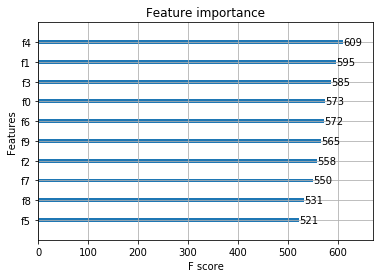

In [124]:
plot_importance(xgb)
plt.show()

画出来的树很模糊.

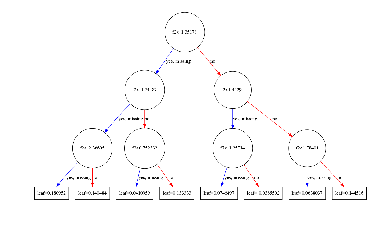

In [143]:
ax=plot_tree(xgb,num_trees=0)
plt.show()

### 组合特征(生成新的特征)

使用GBDT生成新的特征,这里只用了30颗树

In [105]:
X,y=make_hastie_10_2(random_state=0)
X=pd.DataFrame(X)
y=pd.DataFrame(y)

In [106]:
y.columns={"label"}
label={-1:0,1:1}
y.label=y.label.map(label)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [108]:
X_train.shape

(9600, 10)

In [109]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9
843,-1.696838,-0.851699,-0.922525,0.923324,-0.395004,0.709935,-0.042934,-0.649640,-0.318538,-1.872091
9450,0.235742,-0.134053,-0.105796,1.635922,0.388091,-0.337705,-0.424280,0.170233,1.450414,-0.211502
7766,0.889241,-0.310546,-0.978214,0.986720,0.304275,-1.228938,1.245357,-0.908876,3.678521,-0.813448
9802,-0.333380,0.015419,2.148760,-0.909960,1.298145,-0.460775,0.750866,-1.151144,0.685288,0.303376
8555,1.825373,0.203503,-0.344880,0.848101,-0.449497,0.898452,-0.314597,0.110325,-0.221885,-2.015231


In [110]:
clf = XGBClassifier(
    n_estimators=30,#三十棵树
    learning_rate =0.3,
    max_depth=3,
    min_child_weight=1,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=12,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=27)

In [112]:
clf.fit(X_train, y_train)

/usr/local/python/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/python/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.3,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=30, n_jobs=1, nthread=12, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

In [113]:
clf.score(X_test,y_test)

0.89000000000000001

In [87]:
train_new_feature= clf.apply(X_train)#每个样本在每颗树叶子节点的索引值
test_new_feature= clf.apply(X_test)
train_new_feature2 = pd.DataFrame(train_new_feature)
test_new_feature2 = pd.DataFrame(test_new_feature)

In [88]:
train_new_feature2.shape

(9600, 30)

In [89]:
train_new_feature2.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,8,11,9,9,10,8,11,12,9,9,...,10,8,10,11,9,10,10,8,11,12
1,10,11,9,11,11,9,11,12,9,9,...,10,9,11,11,9,10,10,8,11,13
2,10,11,9,12,10,9,11,12,9,9,...,10,9,14,11,10,13,10,8,11,13
3,10,11,9,10,10,9,11,14,9,9,...,8,9,11,12,9,10,10,8,13,12
4,12,11,9,9,10,7,11,12,9,10,...,10,8,13,11,9,10,10,8,12,12


现在每个样本就是100维的,每一维表示原样本在这颗树的叶子节点的索引,这样我们就得到了新的特征.下面使用新的特征训练

In [90]:
clf.fit(train_new_feature2, y_train)

/usr/local/python/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/python/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.3,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=30, n_jobs=1, nthread=12, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

In [91]:
clf.score(test_new_feature2,y_test)

0.87541666666666662

### 原特征和组合特征一起训练

这里只用新的特征,也可以有很好的预测效果,说明新的特征是有用的,
现在我们把旧的特征和新的特征整合在一起训练.先写把特征合并的方法

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from  sklearn.datasets  import  make_hastie_10_2
from xgboost.sklearn import XGBClassifier
##载入示例数据 10维度
X, y = make_hastie_10_2(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)##test_size测试集合所占比例
##X_train_1用于生成模型  X_train_2用于和新特征组成新训练集合
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.6, random_state=0)

In [7]:
import numpy as np
def mergeToOne(X,X2):
    X3=[]
    for i in range(X.shape[0]):
        tmp=np.array([list(X[i]),list(X2[i])])
        X3.append(list(np.hstack(tmp)))
    X3=np.array(X3)
    return X3

In [8]:
clf = XGBClassifier(
 learning_rate =0.3, #默认0.3
 n_estimators=30, #树的个数
 max_depth=3,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.6,
 colsample_bytree=0.6,
 objective= 'binary:logistic', #逻辑回归损失函数
 nthread=4,  #cpu线程数
 scale_pos_weight=1,
 reg_alpha=1e-05,
 reg_lambda=1,
 seed=27)  #随机种子

In [9]:
clf.fit(X_train_1, y_train_1)
new_feature= clf.apply(X_train_2)

In [10]:
X_train_new2=mergeToOne(X_train_2,new_feature)
new_feature_test= clf.apply(X_test)
X_test_new=mergeToOne(X_test,new_feature_test)

In [11]:
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=2000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.6,
 colsample_bytree=0.6,
 objective= 'binary:logistic', 
 nthread=4, 
 scale_pos_weight=1,
 reg_alpha=1e-05,
 reg_lambda=1,
 seed=27)

In [12]:
model.fit(X_train_new2, y_train_2)
y_pre= model.predict(X_test_new)
y_pro= model.predict_proba(X_test_new)[:,1] 
print("AUC Score : %f" % metrics.roc_auc_score(y_test, y_pro) )
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pre) )

AUC Score : 0.992485
Accuracy : 0.9563


In [14]:
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=2000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.6,
 subsample=0.7,
 colsample_bytree=0.8,
 objective= 'binary:logistic', 
 nthread=4, 
 scale_pos_weight=1,
 reg_alpha=1e-05,
 reg_lambda=1,
 seed=27)
model.fit(X_train_new2, y_train_2)
y_pre= model.predict(X_test_new)
y_pro= model.predict_proba(X_test_new)[:,1] 
print("AUC Score : %f" % metrics.roc_auc_score(y_test, y_pro) )
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pre) )

AUC Score : 0.993615
Accuracy : 0.9625


生成新的特征后再和原来的特征一起合并作为训练数据,这是目前最好的效果,这里还没有进行网格搜索,应该有更好的效果